<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/ARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 718 kB 5.2 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import torch
import pyro
from torch import nn
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist
import pandas as pd
import numpy as np
from pyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

In [3]:
class ARDRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.alpha = pyro.sample('alpha', dist.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).expand([in_features]).to_event(1))
        self.one_over_sqrt_alpha = 1/torch.sqrt(self.alpha)

        self.sigma2 = pyro.sample('sigma2', dist.InverseGamma(torch.tensor([1.0]), torch.tensor([1.0])))
        self.sigma = torch.sqrt(self.sigma2)

        self.linear = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear.weight = PyroSample(dist.Normal(0., self.sigma*self.one_over_sqrt_alpha).expand([out_features, in_features]).to_event(2))

    def forward(self, x, y=None):
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, self.sigma), obs=y)
        return mean

In [8]:
# Making training data
def make_training_data(num_samples, dims, sigma, mu=0):
  """
  Creates training data when half of the regressors are 0
  """
  x = np.random.randn(num_samples, dims).astype(np.float64)
  w = sigma * np.random.randn(1,dims).astype(np.float64)
  noise = np.random.randn(num_samples).astype(np.float64)
  noise = 0
  w[:,:int(dims/2)] = 0.
  y = np.matmul(x, w.T) + (noise/2) + mu

  y = torch.tensor(y, dtype = torch.float)
  x = torch.tensor(x, dtype = torch.float)
  return y, x, w


def sep_training_test(y,x,test):
  y_train = y[test:,:]
  x_train = x[test:,:]
  
  y_test = y[:test,:]
  x_test = x[:test,:]
  return y_train, y_test, x_train, x_test

num_features = 1

y, x, w = make_training_data(100, num_features,1, mu=0)
y_train, y_test, x_train, x_test = sep_training_test(y,x,20)

In [9]:
y_train.shape

torch.Size([80, 1])

In [10]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoContinuous
from pyro.infer import SVI, Trace_ELBO

model = ARDRegression(num_features, 1)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [13]:
from scipy.stats import norm as NormalDist

pyro.clear_param_store()
num_iterations = 2000
step_ids = []
average_log_predictives = []

mse_loss = nn.MSELoss()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train.squeeze())
    #step_ids.append(j)       

    if j % 100 == 0:
      print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)
      train_predictions = predictive_svi(x_train, None)
      test_predictions = predictive_svi(x_test, None)
      train_obs = train_predictions['obs']
      test_obs = test_predictions['obs']
      mse_loss(torch.tensor(train_obs), torch.tile(np.squeeze(y_train), (num_samples, 1)))
      average_train_log_mse = torch.mean(torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1)))))
      average_test_log_mse = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))
    
      print(average_train_log_mse)
      print(average_test_log_mse)

      step_ids.append(j)
      average_log_predictives.append(average_test_log_mse)

[iteration 0001] loss: 1.2786
tensor(0.1791)
tensor(0.1580)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[iteration 0101] loss: 0.8203
tensor(-0.2637)
tensor(-0.2237)
[iteration 0201] loss: 0.8223
tensor(-0.2415)
tensor(-0.2365)
[iteration 0301] loss: 0.8219
tensor(-0.2414)
tensor(-0.2279)
[iteration 0401] loss: 0.8377
tensor(-0.2289)
tensor(-0.2340)
[iteration 0501] loss: 0.8486
tensor(-0.2215)
tensor(-0.2250)
[iteration 0601] loss: 0.8172
tensor(-0.2392)
tensor(-0.2226)
[iteration 0701] loss: 0.8275
tensor(-0.2357)
tensor(-0.2684)
[iteration 0801] loss: 0.8231
tensor(-0.2486)
tensor(-0.2504)
[iteration 0901] loss: 0.8340
tensor(-0.2199)
tensor(-0.2686)
[iteration 1001] loss: 0.8247
tensor(-0.2318)
tensor(-0.2859)
[iteration 1101] loss: 0.8209
tensor(-0.2251)
tensor(-0.2211)
[iteration 1201] loss: 0.8246
tensor(-0.2454)
tensor(-0.2241)
[iteration 1301] loss: 0.8232
tensor(-0.2003)
tensor(-0.2415)
[iteration 1401] loss: 0.8227
tensor(-0.2384)
tensor(-0.2425)
[iteration 1501] loss: 0.8425
tensor(-0.2332)
tensor(-0.2397)
[iteration 1601] loss: 0.8240
tensor(-0.2988)
tensor(-0.2389)
[iterati

In [14]:
test_obs[0]

tensor([-0.2303, -0.3146, -0.6047,  0.9967, -0.7925, -0.1717, -0.8014, -0.3574,
         0.1649,  0.2467,  0.3326, -0.1133,  0.2615, -1.3690, -0.3570,  0.6282,
         0.3765,  0.0887, -1.0627, -0.9930])

In [15]:
y_test

tensor([[-0.2171],
        [ 0.4406],
        [-0.2959],
        [ 0.5772],
        [ 0.1957],
        [-0.0404],
        [ 0.0933],
        [ 0.1302],
        [ 0.3192],
        [ 0.4035],
        [-0.1028],
        [ 0.1611],
        [-0.5424],
        [-0.4109],
        [-0.3411],
        [ 0.3014],
        [-0.1120],
        [ 0.0190],
        [ 0.1094],
        [-0.4765]])

In [16]:
NormalDist(0,1).pdf(0)

0.3989422804014327

Text(0, 0.5, 'Average log predictive MSE')

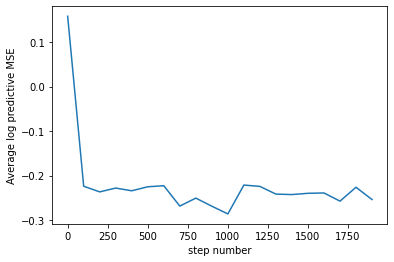

In [17]:
plt.plot(step_ids, average_log_predictives)
plt.xlabel("step number")
plt.ylabel("Average log predictive MSE")

In [103]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([13.3730])
AutoDiagonalNormal.scale tensor([0.1569])


In [104]:
print('Actual value of w: {}'.format(w))
print('Fitted median of posterior: {}'.format(guide.quantiles([0.5])))

Actual value of w: [[13.41762172]]
Fitted median of posterior: {'linear.weight': tensor([[[13.3730]]])}


In [105]:
guide.quantiles([0.5])

{'linear.weight': tensor([[[13.3730]]])}

In [141]:
x_train.shape

torch.Size([80, 10])

In [38]:
from pyro.infer import MCMC, NUTS, HMC
nuts_kernel = NUTS(model, jit_compile=False, step_size=1)
num_samples = 200

mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=100,
    num_chains=1,
)


mcmc_step_ids = []
mcmc_average_test_log_accuracy = []

mse_loss = torch.nn.MSELoss()

for i in range(10):

  mcmc.run(x_train, y_train)
  #mcmc.summary(prob=0.5)
  #diagnostics = mcmc.diagnostics()

  print(diagnostics)
  samples = mcmc.get_samples()
  mcmc_predictive = Predictive(model, samples)
  
  test_obs = mcmc_predictive(x_test, None)['obs']
  train_obs = mcmc_predictive(x_train, None)['obs']
  print(test_obs[0])
  print(y_test[0])

  print(train_obs[0])
  print(y_train[0])

  average_test_log_accuracy = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))
  average_train_log_accuracy = torch.mean(torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1)))))
  print(average_train_log_accuracy)
  print(average_test_log_accuracy)
  mcmc_step_ids.append(i*num_samples)
  mcmc_average_test_log_accuracy.append(average_test_log_accuracy)

Sample: 100%|██████████| 300/300 [00:02, 142.99it/s, step size=8.50e-01, acc. prob=0.938]


{'linear.weight': OrderedDict([('n_eff', tensor([[95.2513]])), ('r_hat', tensor([[0.9951]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.97}}
tensor([ 0.1089, -0.5878,  1.0356, -0.5184,  1.0835, -0.5418, -0.3164, -0.3468,
         0.6241,  0.2418,  0.2635,  1.0191, -0.4989, -1.7539,  2.1181, -0.4484,
        -0.8091, -1.1184, -0.0139, -1.6690])
tensor([-0.2171])
tensor([-0.2804, -1.2956, -1.7418,  0.4332,  1.0775, -0.5718,  1.6834,  0.2837,
        -2.1782, -0.1252,  0.7037,  0.5081,  0.4392,  0.2478,  1.9090,  0.2424,
         0.7215,  0.4926, -1.0732, -1.6874, -0.6593, -0.5671,  0.8140,  0.9842,
         1.4336,  0.3502, -0.2906, -0.3515, -1.3654, -0.0214,  0.3860, -1.7385,
         1.5970,  0.4214,  0.3758, -0.0113, -0.1942, -1.3491, -0.8018,  0.0166,
         0.1062,  1.5913,  0.4246, -0.2129, -0.6871,  0.5183,  1.0274, -0.9787,
         0.2252, -0.2504, -1.4032, -0.2898, -0.4158, -1.5903, -1.0358, -0.3100,
        -0.7148,  0.6388, -0.1188, -1.5219, -0.8012

Sample: 100%|██████████| 300/300 [00:01, 214.27it/s, step size=1.07e+00, acc. prob=0.880]


{'linear.weight': OrderedDict([('n_eff', tensor([[76.1820]])), ('r_hat', tensor([[0.9951]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.915}}
tensor([-0.3298, -0.3345,  1.5878,  0.6321,  0.0483, -0.3298, -0.8184,  0.0915,
         0.1177, -1.0254, -1.5448, -1.9561, -0.3904,  0.0046,  0.0429,  0.8676,
        -0.1253, -0.0217, -1.1959,  0.0168])
tensor([-0.2171])
tensor([ 1.7701e+00, -8.9344e-02,  1.6156e+00,  4.2510e-02, -8.9621e-01,
        -5.3957e-01, -3.0083e-01, -2.1497e-01, -4.9875e-01, -5.9283e-01,
        -5.5255e-01, -1.5678e+00, -8.9477e-01,  2.5816e-02,  2.5636e-01,
         4.2050e-01,  1.3147e-01,  2.1079e-01,  7.9325e-01, -5.5785e-01,
        -6.2330e-01,  9.8672e-02,  9.5765e-01, -2.5137e+00, -1.2333e+00,
        -1.2658e+00, -1.2552e+00,  3.7464e-01,  1.5298e+00, -4.9221e-01,
        -1.6090e-01,  3.3169e-01,  1.5625e+00,  7.3941e-01, -5.2393e-01,
        -4.1063e-01, -6.0027e-01, -9.1478e-01, -1.7954e+00,  1.2587e+00,
        -2.3962e-03, -1.21

Sample: 100%|██████████| 300/300 [00:01, 154.13it/s, step size=5.30e-01, acc. prob=0.968]


{'linear.weight': OrderedDict([('n_eff', tensor([[43.1782]])), ('r_hat', tensor([[0.9997]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.995}}
tensor([ 0.3841,  0.3897,  0.9233, -0.7715, -1.0504, -0.2728,  1.3818,  0.1877,
        -1.0242,  1.5895,  2.1960, -0.7221, -1.1566, -0.3786,  0.0139,  0.0414,
        -0.7761, -0.3431, -0.6997,  0.2026])
tensor([-0.2171])
tensor([ 0.1757, -0.2922,  0.1051,  0.2551, -1.2743, -0.7667, -0.2774, -0.5886,
        -0.5629,  0.0056,  1.3260,  0.0680,  0.9001, -1.6310, -0.7223, -0.4222,
         0.0432,  1.7647,  1.0127,  0.2544,  0.6945,  0.3108, -0.0907, -0.5199,
         0.2847,  1.4172,  0.4484, -2.5483, -1.5004,  0.6354,  1.3746,  0.2571,
         0.3645, -1.4896,  0.5265, -0.2323,  0.7201, -0.8408, -0.6626, -0.1402,
        -0.0296, -0.2344,  0.3216, -1.0775,  0.8662,  1.2212,  0.0943,  0.5463,
         0.3404,  0.1144,  0.6171,  0.1356, -0.0486, -0.5817, -0.8171,  2.3083,
         0.4467, -0.0591,  1.4567,  0.1474, -0.146

Sample: 100%|██████████| 300/300 [00:01, 186.47it/s, step size=9.43e-01, acc. prob=0.895]


{'linear.weight': OrderedDict([('n_eff', tensor([[86.6302]])), ('r_hat', tensor([[1.0071]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.92}}
tensor([ 1.2169,  0.3561, -1.5274,  0.0933, -0.1118, -0.6855,  1.3271, -0.1079,
         0.2108,  1.4925,  1.0379,  0.0095,  0.2439, -0.8525, -0.9460,  0.2150,
        -2.4446,  0.9809,  1.7823,  1.2224])
tensor([-0.2171])
tensor([-7.9853e-01, -1.4389e-01,  2.1788e-02,  7.3920e-02, -6.9861e-01,
        -3.3570e-01, -1.6443e-01,  2.0628e-01,  1.2703e-01,  5.9366e-01,
        -9.6325e-01,  1.3092e-01,  4.8997e-01,  1.7296e+00,  1.1707e+00,
        -1.6113e+00,  1.8674e+00,  5.6316e-02,  3.1380e-01,  1.3419e-04,
         3.4259e-01, -1.9495e-01,  1.4929e+00, -5.6453e-01, -2.3912e-01,
         1.4380e+00, -5.2947e-01, -2.3287e+00, -9.2126e-01,  8.5431e-01,
        -8.6235e-01, -7.0240e-01,  6.8611e-02,  6.1809e-01, -2.4622e-01,
         2.0660e+00,  2.4245e+00,  4.8456e-01, -3.6878e-01, -7.8267e-02,
        -1.3299e+00, -4.280

Sample: 100%|██████████| 300/300 [00:01, 207.73it/s, step size=8.70e-01, acc. prob=0.931]


{'linear.weight': OrderedDict([('n_eff', tensor([[76.5066]])), ('r_hat', tensor([[1.0288]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.945}}
tensor([-0.6497,  0.1233,  0.3573, -0.4539, -0.5474, -0.8303, -1.1369, -0.4748,
         0.2582, -0.3557,  0.2694,  0.2051,  0.9743, -0.0076, -0.3878, -1.1854,
         0.4023,  0.8576, -1.9877,  0.7496])
tensor([-0.2171])
tensor([ 0.5607, -1.6848, -0.0188,  0.2792, -1.9629, -0.2895, -1.0880,  1.3667,
        -1.2305, -0.5941, -0.2674, -0.0075, -0.7756, -1.0843,  0.4759,  0.2522,
         0.3016, -0.8581, -0.2755,  1.9815, -0.6432, -0.3197, -0.3089,  1.0636,
         0.1364, -0.7554,  0.9654,  0.4044, -1.4733,  1.5230, -1.0290,  0.7130,
        -0.5049, -0.3997,  0.7210,  0.4639,  0.9535,  2.0187,  1.7530, -0.2950,
        -0.4222,  0.4556, -0.6773,  0.5350, -0.5589, -0.6375, -0.5300,  0.7930,
        -0.3367, -1.1089, -0.2949,  0.4619, -0.5393, -0.5242, -0.0410,  0.0471,
        -0.9289,  0.8580, -0.6745, -0.0495,  0.667

Sample: 100%|██████████| 300/300 [00:01, 210.87it/s, step size=1.18e+00, acc. prob=0.816]


{'linear.weight': OrderedDict([('n_eff', tensor([[133.1688]])), ('r_hat', tensor([[0.9951]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.91}}
tensor([-0.2783, -1.1077,  0.0470, -0.0483, -0.2857, -0.1462,  0.7891, -0.5943,
         0.4024,  1.4273,  0.6795, -1.3530, -0.1495, -0.5243, -1.5231,  0.0342,
         1.0292, -0.2090,  0.7121,  0.1286])
tensor([-0.2171])
tensor([ 0.0662, -0.6536, -0.4266,  1.1221, -0.8421,  1.5451,  0.5285,  0.0384,
        -0.3334, -0.4842, -0.3569, -0.6688, -1.2979,  0.5322,  0.2020, -1.1705,
         1.7167, -1.2904, -0.5186, -1.6649, -1.9641, -1.0586, -0.3229, -1.0320,
        -0.5032,  0.2142, -0.5176, -0.0996,  1.2379,  0.0978, -0.1695, -0.8741,
         0.5989,  0.3855,  0.4015, -0.6998, -3.5055,  0.0646,  0.8113, -0.3044,
        -1.8095,  0.4044,  0.6600, -1.2003, -0.2500,  0.2161,  1.2306, -0.2543,
        -0.9099, -0.5621,  0.4130, -0.5200,  0.1022, -0.3546, -1.2500, -2.2817,
        -0.0107,  1.0602,  0.3330,  0.8588,  1.121

Sample: 100%|██████████| 300/300 [00:01, 246.57it/s, step size=1.28e+00, acc. prob=0.675]


{'linear.weight': OrderedDict([('n_eff', tensor([[184.7250]])), ('r_hat', tensor([[0.9982]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.69}}
tensor([ 1.3472,  0.4537, -0.5311,  0.2167,  0.1464,  0.3592,  1.4806, -1.2748,
         0.0619,  0.8933, -0.3774,  1.5311, -0.8358, -0.2804,  0.3515,  1.3824,
         1.0674,  1.0888,  1.2722, -0.9611])
tensor([-0.2171])
tensor([ 0.5701,  0.6762, -0.3814, -0.6790, -0.2116, -1.0312,  0.2429,  0.3474,
        -0.2141,  1.7522, -1.2321,  0.9141,  0.2925,  2.0217,  0.4172, -0.3991,
        -1.0816, -0.9937, -0.3413,  0.2225,  1.1942, -0.7645,  0.4820, -0.4696,
         0.9179, -0.2349,  0.1992, -0.1472, -0.2054,  0.4938, -1.5455,  0.7314,
         0.9609,  0.0212, -1.9763,  0.1073, -1.3578,  0.0079, -1.6460, -0.5547,
        -1.5578,  0.5287,  1.5053, -0.5349,  0.7506, -0.1453, -0.4300, -0.7755,
        -0.8811,  1.3467, -0.3143, -0.5724,  0.2293, -0.1652, -1.8831,  0.4163,
        -0.0915,  0.2423,  1.3326, -1.5745, -1.788

Sample: 100%|██████████| 300/300 [00:02, 144.64it/s, step size=6.40e-01, acc. prob=0.964]


{'linear.weight': OrderedDict([('n_eff', tensor([[62.3715]])), ('r_hat', tensor([[1.0142]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.99}}
tensor([-0.2796, -0.3652, -1.2182,  0.3267,  0.5324, -0.6619, -0.5018,  0.0311,
        -0.0327,  0.9244,  0.0116, -0.2701,  0.8323,  0.2888, -0.0159, -0.7694,
        -0.5520,  0.9062,  0.1092,  0.5184])
tensor([-0.2171])
tensor([-0.0268,  0.8212,  0.0239,  0.8444, -0.4041, -0.9492,  0.1166,  0.5458,
        -0.6199, -1.0047,  0.4103,  0.9630,  0.0032,  2.0960,  1.1587, -0.2147,
        -0.3582,  0.5720,  0.1614,  0.7794, -0.1482, -0.1789, -0.0797,  0.2651,
        -1.1334,  1.1482, -0.6743, -2.2520,  1.0716, -0.3522,  1.5318, -0.7038,
         0.0448,  0.2756, -0.4104, -0.1088,  1.5193, -0.0634, -0.3907, -0.0265,
         0.4113, -0.8039, -0.2321, -0.8251, -0.5118, -0.5673,  2.4093, -0.6342,
         0.6135,  0.3917,  1.1757, -0.7285, -0.1314, -0.0761, -1.1982, -0.0892,
        -0.0470,  1.4206,  0.1079,  1.4820, -0.7041

Sample: 100%|██████████| 300/300 [00:01, 161.24it/s, step size=5.87e-01, acc. prob=0.950]


{'linear.weight': OrderedDict([('n_eff', tensor([[131.1162]])), ('r_hat', tensor([[0.9951]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.965}}
tensor([-0.7773,  0.6136,  0.1069, -0.9184, -0.9251,  0.5138, -1.3453,  0.9210,
         1.5331, -0.0928,  0.6065,  0.6687, -0.0370,  1.9841, -0.3735,  0.3318,
        -0.1429,  0.1591, -0.1929,  1.4866])
tensor([-0.2171])
tensor([-1.1368, -0.4269,  0.5309,  1.0875,  0.1679, -0.1675,  0.9258, -0.2049,
         0.4120, -1.5970,  0.6043,  0.4557, -1.2607,  0.5226, -0.3901, -0.2252,
        -0.4254, -0.2120, -0.8363, -0.9958,  2.0476,  0.0475, -1.4629,  1.6334,
        -0.1637,  0.7880,  0.7262,  0.1471, -1.2638, -0.3212, -0.8714, -2.1601,
        -0.1786,  0.4498,  0.1498,  1.7457, -1.3100, -1.2261,  0.7868, -1.1009,
         0.2803,  0.0606,  0.8947, -0.8641, -0.9234,  0.1484,  1.7471, -0.5602,
        -0.1289,  1.1009, -1.5132,  0.0695,  1.4941,  0.2933,  0.0776,  0.6728,
         0.9048, -0.1830, -0.5001,  0.3552, -0.02

Sample: 100%|██████████| 300/300 [00:01, 197.82it/s, step size=8.45e-01, acc. prob=0.908]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([-0.3612,  0.7571,  1.9885, -2.5343,  1.7598, -0.8409, -1.1702,  0.9699,
         1.1073, -1.3280, -0.5773,  0.0747,  0.2150,  0.5801,  0.0174,  0.4283,
         2.1796, -1.3843, -0.6281, -0.1917])
tensor([-0.2171])
tensor([ 0.2214,  0.1388, -0.8943,  0.6639,  0.6619,  0.8040, -0.1283, -0.0038,
         1.1079,  0.2224, -2.7888, -1.1729,  0.4014,  0.2699,  1.4307,  0.8384,
        -0.3187,  0.5594, -1.6078,  1.1580,  0.0626,  0.5824,  0.4470,  1.2296,
        -0.3263, -1.3644, -0.2244,  1.2274,  0.3947,  0.1431,  0.3325, -0.0061,
         1.2691, -0.5190, -0.1898, -0.3656,  0.3829, -0.4631,  1.8996, -0.1105,
         1.2884,  0.2707, -0.0285, -0.2712,  0.4244, -1.2617, -0.3444, -0.6652,
        -1.1953, -0.9326,  1.2173, -0.0632, -0.9153,  0.5850,  0.2296, -1.2128,
        -0.9236, -1.5271,  0.1708,  1.0514, -2.03

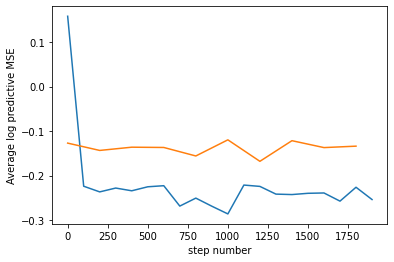

In [39]:
plt.plot(step_ids, average_log_predictives)
plt.xlabel("step number")
plt.ylabel("Average log predictive MSE")
plt.plot(mcmc_step_ids, mcmc_average_test_log_accuracy)